In [ ]:
import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Reshape, Flatten
from tensorflow.keras.layers import Conv1D, TimeDistributed, UpSampling1D, MaxPooling1D
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model

### Some global variables

In [ ]:
Rnum = 4000
x = np.linspace(0.0,1.0,num=128)
dx = 1.0/np.shape(x)[0]
tsteps = np.linspace(0.0,2.0,num=1000)
dt = 2.0/np.shape(tsteps)[0]
mode = 'train'

### Functions for full-order snapshots of Burgers Equation

In [3]:
def exact_solution(Rnum,t):
    t0 = np.exp(Rnum/8.0)

    return (x/(t+1))/(1.0+np.sqrt((t+1)/t0)*np.exp(Rnum*(x*x)/(4.0*t+4)))

def collect_snapshots(Rnum):
    snapshot_matrix = np.zeros(shape=(np.shape(x)[0],np.shape(tsteps)[0]))

    trange = np.arange(np.shape(tsteps)[0])
    for t in trange:
        snapshot_matrix[:,t] = exact_solution(Rnum,tsteps[t])[:]

    return np.transpose(snapshot_matrix)

### Collect some snapshot data for CNN-LSTM embedding

In [4]:
snapshots_train = collect_snapshots(Rnum)
snapshots_train = np.expand_dims(snapshots_train,-1)

snapshots_valid = snapshots_train[500:]
snapshots_train = snapshots_train[:500]

/home/rmlans/anaconda3/envs/tf2_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


### Do some shifting for evolution predictions

In [5]:
snapshots_evolve = snapshots_train[1:]
snapshots_train = snapshots_train[0:-1]

### ML related presets

In [6]:
weights_filepath = 'best_weights.h5'
lrate = 0.001

def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Autoencoder and LSTM

In [7]:
# Encoder
encoder_inputs = Input(shape=(128,1),name='Field')

x = Conv1D(25,kernel_size=3,activation='relu',padding='same')(encoder_inputs)
enc_l2 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(15,kernel_size=3,activation='relu',padding='same')(enc_l2)
enc_l3 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(10,kernel_size=3,activation='relu',padding='same')(enc_l3)
enc_l4 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(5,kernel_size=3,activation='relu',padding='same')(enc_l4)
enc_l5 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(2,kernel_size=3,activation=None,padding='same')(enc_l5)
enc_l6 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(1,kernel_size=3,activation=None,padding='same')(enc_l6)
encoded = MaxPooling1D(2,padding='same')(x)

# LSTM
# encoded_lstm = Flatten()(encoded)
# parameter_inputs = Input(shape=(1,),name='Viscosity')
# lstm_inputs = tf.keras.layers.concatenate([encoded_lstm, parameter_inputs])
# lstm_inputs = Reshape((1,3))(lstm_inputs)

lstm_inputs = Reshape((1,2))(encoded)
x = LSTM(40,input_shape=(1, 3),return_sequences=True)(lstm_inputs)
# x = LSTM(40,return_sequences=True)(x)
lstm_outputs = Dense(2,activation=None)(x)

# Decoder architecture (common)
dec_layer_1 = Conv1D(1,kernel_size=3,activation='relu',padding='same')
dec_layer_2 = Conv1D(5,kernel_size=3,activation='relu',padding='same')
dec_layer_3 = Conv1D(10,kernel_size=3,activation='relu',padding='same')
dec_layer_4 = Conv1D(15,kernel_size=3,activation='relu',padding='same')
dec_layer_5 = Conv1D(20,kernel_size=3,activation='relu',padding='same')
dec_layer_6 = Conv1D(25,kernel_size=3,activation='relu',padding='same')
dec_layer_7 = Conv1D(1,1,activation=None,padding='same')

# Decoder - using LSTM
lstm_decoder_inputs = Reshape((2,1))(lstm_outputs)

x = dec_layer_1(lstm_decoder_inputs)
dec_l1 = UpSampling1D(2)(x)

x = dec_layer_2(dec_l1)
dec_l2 = UpSampling1D(2)(x)

x = dec_layer_3(dec_l2)
dec_l3 = UpSampling1D(2)(x)

x = dec_layer_4(dec_l3)
dec_l4 = UpSampling1D(2)(x)

x = dec_layer_5(dec_l4)
dec_l5 = UpSampling1D(2)(x)

x = dec_layer_6(dec_l5)
dec_l6 = UpSampling1D(2)(x)

lstm_decoder_outputs = dec_layer_7(dec_l6)

# Decoder - using AE only
x = dec_layer_1(encoded)
dec_l1 = UpSampling1D(2)(x)

x = dec_layer_2(dec_l1)
dec_l2 = UpSampling1D(2)(x)

x = dec_layer_3(dec_l2)
dec_l3 = UpSampling1D(2)(x)

x = dec_layer_4(dec_l3)
dec_l4 = UpSampling1D(2)(x)

x = dec_layer_5(dec_l4)
dec_l5 = UpSampling1D(2)(x)

x = dec_layer_6(dec_l5)
dec_l6 = UpSampling1D(2)(x)

ae_decoder_outputs = dec_layer_7(dec_l6)
    
model = Model(inputs=[encoder_inputs],outputs=[ae_decoder_outputs,lstm_decoder_outputs],name='CAE-LSTM')
   
# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination])    
model.summary()

num_epochs = 500
batch_size = 32

if mode == 'train':
    train_history = model.fit(x=snapshots_train, 
                              y=[snapshots_train,snapshots_evolve], 
                              epochs=num_epochs, 
                              batch_size=batch_size, 
                              callbacks=callbacks_list,
                              validation_split=0.1)

Model: "CAE-LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 25)      100         Field[0][0]                      
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 64, 25)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 64, 15)       1140        max_pooling1d[0][0]              
___________________________________________________________________________________________

12/15 [=======================>......] - ETA: 0s - loss: 0.0538 - conv1d_12_loss: 0.0269 - conv1d_12_1_loss: 0.0269 - conv1d_12_coeff_determination: -660578.0000 - conv1d_12_1_coeff_determination: -119665912.0000
Epoch 00001: val_loss improved from inf to 0.02730, saving model to best_weights.h5
15/15 [==============================] - 1s 97ms/step - loss: 0.0517 - conv1d_12_loss: 0.0259 - conv1d_12_1_loss: 0.0259 - conv1d_12_coeff_determination: -528684.3125 - conv1d_12_1_coeff_determination: -95732952.0000 - val_loss: 0.0273 - val_conv1d_12_loss: 0.0137 - val_conv1d_12_1_loss: 0.0136 - val_conv1d_12_coeff_determination: -466.5908 - val_conv1d_12_1_coeff_determination: -466.0623
Epoch 2/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0381 - conv1d_12_loss: 0.0190 - conv1d_12_1_loss: 0.0190 - conv1d_12_coeff_determination: -455.9846 - conv1d_12_1_coeff_determination: -455.3869
Epoch 00002: val_loss did not improve from 0.02730
15/15 [==============================] - 0s 

15/15 [==============================] - ETA: 0s - loss: 0.0237 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0118 - conv1d_12_coeff_determination: -0.6907 - conv1d_12_1_coeff_determination: -0.6869
Epoch 00013: val_loss improved from 0.01184 to 0.01176, saving model to best_weights.h5
15/15 [==============================] - 1s 52ms/step - loss: 0.0237 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0118 - conv1d_12_coeff_determination: -0.6907 - conv1d_12_1_coeff_determination: -0.6869 - val_loss: 0.0118 - val_conv1d_12_loss: 0.0059 - val_conv1d_12_1_loss: 0.0059 - val_conv1d_12_coeff_determination: 0.1772 - val_conv1d_12_1_coeff_determination: 0.1796
Epoch 14/500
15/15 [==============================] - ETA: 0s - loss: 0.0236 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0118 - conv1d_12_coeff_determination: -0.6435 - conv1d_12_1_coeff_determination: -0.6391
Epoch 00014: val_loss improved from 0.01176 to 0.01166, saving model to best_weights.h5
15/15 [==============================

Epoch 26/500
15/15 [==============================] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5525 - conv1d_12_1_coeff_determination: -0.5484
Epoch 00026: val_loss did not improve from 0.01140
15/15 [==============================] - 1s 42ms/step - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5525 - conv1d_12_1_coeff_determination: -0.5484 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2465 - val_conv1d_12_1_coeff_determination: 0.2488
Epoch 27/500
11/15 [=====================>........] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5682 - conv1d_12_1_coeff_determination: -0.5642
Epoch 00027: val_loss did not improve from 0.01140
15/15 [==============================] - 0s 32ms/step - loss: 0.0235 - conv1d_12_loss: 0.0118 - co

Epoch 39/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5826 - conv1d_12_1_coeff_determination: -0.5786
Epoch 00039: val_loss did not improve from 0.01134
15/15 [==============================] - 1s 46ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5387 - conv1d_12_1_coeff_determination: -0.5345 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2549 - val_conv1d_12_1_coeff_determination: 0.2571
Epoch 40/500
15/15 [==============================] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5397 - conv1d_12_1_coeff_determination: -0.5356
Epoch 00040: val_loss did not improve from 0.01134
15/15 [==============================] - 1s 39ms/step - loss: 0.0235 - conv1d_12_loss: 0.0118 - co

Epoch 52/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5907 - conv1d_12_1_coeff_determination: -0.5866
Epoch 00052: val_loss did not improve from 0.01134
15/15 [==============================] - 1s 39ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5691 - conv1d_12_1_coeff_determination: -0.5648 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2478 - val_conv1d_12_1_coeff_determination: 0.2501
Epoch 53/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5678 - conv1d_12_1_coeff_determination: -0.5638
Epoch 00053: val_loss did not improve from 0.01134
15/15 [==============================] - 0s 21ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - co

Epoch 65/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0118 - conv1d_12_coeff_determination: -0.5903 - conv1d_12_1_coeff_determination: -0.5862
Epoch 00065: val_loss did not improve from 0.01134
15/15 [==============================] - 0s 23ms/step - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5590 - conv1d_12_1_coeff_determination: -0.5551 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2734 - val_conv1d_12_1_coeff_determination: 0.2756
Epoch 66/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5749 - conv1d_12_1_coeff_determination: -0.5708
Epoch 00066: val_loss did not improve from 0.01134
15/15 [==============================] - 0s 20ms/step - loss: 0.0235 - conv1d_12_loss: 0.0118 - co

Epoch 78/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5929 - conv1d_12_1_coeff_determination: -0.5888
Epoch 00078: val_loss did not improve from 0.01134
15/15 [==============================] - 0s 19ms/step - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5893 - conv1d_12_1_coeff_determination: -0.5849 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2406 - val_conv1d_12_1_coeff_determination: 0.2429
Epoch 79/500
15/15 [==============================] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5925 - conv1d_12_1_coeff_determination: -0.5881
Epoch 00079: val_loss did not improve from 0.01134
15/15 [==============================] - 0s 21ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - co

Epoch 91/500
15/15 [==============================] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5666 - conv1d_12_1_coeff_determination: -0.5627
Epoch 00091: val_loss did not improve from 0.01133
15/15 [==============================] - 0s 24ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5666 - conv1d_12_1_coeff_determination: -0.5627 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2608 - val_conv1d_12_1_coeff_determination: 0.2631
Epoch 92/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5754 - conv1d_12_1_coeff_determination: -0.5714
Epoch 00092: val_loss did not improve from 0.01133
15/15 [==============================] - 0s 29ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - co

Epoch 104/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5844 - conv1d_12_1_coeff_determination: -0.5804
Epoch 00104: val_loss did not improve from 0.01133
15/15 [==============================] - 1s 35ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5903 - conv1d_12_1_coeff_determination: -0.5860 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2307 - val_conv1d_12_1_coeff_determination: 0.2330
Epoch 105/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5767 - conv1d_12_1_coeff_determination: -0.5727
Epoch 00105: val_loss did not improve from 0.01133
15/15 [==============================] - 1s 41ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 117/500
15/15 [==============================] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.6466 - conv1d_12_1_coeff_determination: -0.6424
Epoch 00117: val_loss did not improve from 0.01129
15/15 [==============================] - 0s 20ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.6466 - conv1d_12_1_coeff_determination: -0.6424 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2043 - val_conv1d_12_1_coeff_determination: 0.2067
Epoch 118/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5990 - conv1d_12_1_coeff_determination: -0.5950
Epoch 00118: val_loss did not improve from 0.01129
15/15 [==============================] - 0s 32ms/step - loss: 0.0235 - conv1d_12_loss: 0.0118 - 

Epoch 130/500
12/15 [=======================>......] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5751 - conv1d_12_1_coeff_determination: -0.5710
Epoch 00130: val_loss did not improve from 0.01129
15/15 [==============================] - 0s 23ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5682 - conv1d_12_1_coeff_determination: -0.5642 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2507 - val_conv1d_12_1_coeff_determination: 0.2530
Epoch 131/500
12/15 [=======================>......] - ETA: 0s - loss: 0.0233 - conv1d_12_loss: 0.0116 - conv1d_12_1_loss: 0.0116 - conv1d_12_coeff_determination: -0.5579 - conv1d_12_1_coeff_determination: -0.5539
Epoch 00131: val_loss did not improve from 0.01129
15/15 [==============================] - 0s 20ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 143/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0236 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0118 - conv1d_12_coeff_determination: -0.5979 - conv1d_12_1_coeff_determination: -0.5938
Epoch 00143: val_loss did not improve from 0.01129
15/15 [==============================] - 0s 21ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5998 - conv1d_12_1_coeff_determination: -0.5952 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2308 - val_conv1d_12_1_coeff_determination: 0.2331
Epoch 144/500
15/15 [==============================] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5923 - conv1d_12_1_coeff_determination: -0.5884
Epoch 00144: val_loss did not improve from 0.01129
15/15 [==============================] - 0s 25ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 156/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5882 - conv1d_12_1_coeff_determination: -0.5842
Epoch 00156: val_loss did not improve from 0.01129
15/15 [==============================] - 0s 32ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5428 - conv1d_12_1_coeff_determination: -0.5386 - val_loss: 0.0113 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2598 - val_conv1d_12_1_coeff_determination: 0.2620
Epoch 157/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5683 - conv1d_12_1_coeff_determination: -0.5643
Epoch 00157: val_loss did not improve from 0.01129
15/15 [==============================] - 1s 35ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 169/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5655 - conv1d_12_1_coeff_determination: -0.5615
Epoch 00169: val_loss did not improve from 0.01128
15/15 [==============================] - 1s 34ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5392 - conv1d_12_1_coeff_determination: -0.5350 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2482 - val_conv1d_12_1_coeff_determination: 0.2505
Epoch 170/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5762 - conv1d_12_1_coeff_determination: -0.5721
Epoch 00170: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 29ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 182/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0236 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0118 - conv1d_12_coeff_determination: -0.5799 - conv1d_12_1_coeff_determination: -0.5759
Epoch 00182: val_loss did not improve from 0.01128
15/15 [==============================] - 1s 34ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5295 - conv1d_12_1_coeff_determination: -0.5255 - val_loss: 0.0113 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2637 - val_conv1d_12_1_coeff_determination: 0.2659
Epoch 183/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5675 - conv1d_12_1_coeff_determination: -0.5635
Epoch 00183: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 33ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 195/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5569 - conv1d_12_1_coeff_determination: -0.5529
Epoch 00195: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 25ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5736 - conv1d_12_1_coeff_determination: -0.5692 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2292 - val_conv1d_12_1_coeff_determination: 0.2316
Epoch 196/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5900 - conv1d_12_1_coeff_determination: -0.5860
Epoch 00196: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 27ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 208/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0236 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0118 - conv1d_12_coeff_determination: -0.5825 - conv1d_12_1_coeff_determination: -0.5783
Epoch 00208: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 16ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5403 - conv1d_12_1_coeff_determination: -0.5361 - val_loss: 0.0113 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2514 - val_conv1d_12_1_coeff_determination: 0.2537
Epoch 209/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5600 - conv1d_12_1_coeff_determination: -0.5560
Epoch 00209: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 16ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 221/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0118 - conv1d_12_coeff_determination: -0.5666 - conv1d_12_1_coeff_determination: -0.5626
Epoch 00221: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 33ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5842 - conv1d_12_1_coeff_determination: -0.5807 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2281 - val_conv1d_12_1_coeff_determination: 0.2304
Epoch 222/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0234 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5898 - conv1d_12_1_coeff_determination: -0.5858
Epoch 00222: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 32ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 234/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5885 - conv1d_12_1_coeff_determination: -0.5844
Epoch 00234: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 24ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5903 - conv1d_12_1_coeff_determination: -0.5858 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2308 - val_conv1d_12_1_coeff_determination: 0.2332
Epoch 235/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5801 - conv1d_12_1_coeff_determination: -0.5760
Epoch 00235: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 23ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 247/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5810 - conv1d_12_1_coeff_determination: -0.5770
Epoch 00247: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 20ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5593 - conv1d_12_1_coeff_determination: -0.5551 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2472 - val_conv1d_12_1_coeff_determination: 0.2495
Epoch 248/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5725 - conv1d_12_1_coeff_determination: -0.5685
Epoch 00248: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 23ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 260/500
15/15 [==============================] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5871 - conv1d_12_1_coeff_determination: -0.5831
Epoch 00260: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 26ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5871 - conv1d_12_1_coeff_determination: -0.5831 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2273 - val_conv1d_12_1_coeff_determination: 0.2297
Epoch 261/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0233 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5768 - conv1d_12_1_coeff_determination: -0.5728
Epoch 00261: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 30ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 273/500
14/15 [===========================>..] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5936 - conv1d_12_1_coeff_determination: -0.5895
Epoch 00273: val_loss did not improve from 0.01128
15/15 [==============================] - 1s 37ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5756 - conv1d_12_1_coeff_determination: -0.5718 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2480 - val_conv1d_12_1_coeff_determination: 0.2503
Epoch 274/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0233 - conv1d_12_loss: 0.0116 - conv1d_12_1_loss: 0.0116 - conv1d_12_coeff_determination: -0.5561 - conv1d_12_1_coeff_determination: -0.5521
Epoch 00274: val_loss did not improve from 0.01128
15/15 [==============================] - 1s 40ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 286/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5981 - conv1d_12_1_coeff_determination: -0.5940
Epoch 00286: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 23ms/step - loss: 0.0235 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.6566 - conv1d_12_1_coeff_determination: -0.6519 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2141 - val_conv1d_12_1_coeff_determination: 0.2165
Epoch 287/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0233 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5910 - conv1d_12_1_coeff_determination: -0.5869
Epoch 00287: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 22ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

Epoch 299/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0233 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0116 - conv1d_12_coeff_determination: -0.5684 - conv1d_12_1_coeff_determination: -0.5642
Epoch 00299: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 25ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - conv1d_12_1_loss: 0.0117 - conv1d_12_coeff_determination: -0.5901 - conv1d_12_1_coeff_determination: -0.5859 - val_loss: 0.0114 - val_conv1d_12_loss: 0.0057 - val_conv1d_12_1_loss: 0.0057 - val_conv1d_12_coeff_determination: 0.2362 - val_conv1d_12_1_coeff_determination: 0.2386
Epoch 300/500
13/15 [=========================>....] - ETA: 0s - loss: 0.0236 - conv1d_12_loss: 0.0118 - conv1d_12_1_loss: 0.0118 - conv1d_12_coeff_determination: -0.5948 - conv1d_12_1_coeff_determination: -0.5907
Epoch 00300: val_loss did not improve from 0.01128
15/15 [==============================] - 0s 24ms/step - loss: 0.0235 - conv1d_12_loss: 0.0117 - 

KeyboardInterrupt: 

### Check accuracy of Autoencoder

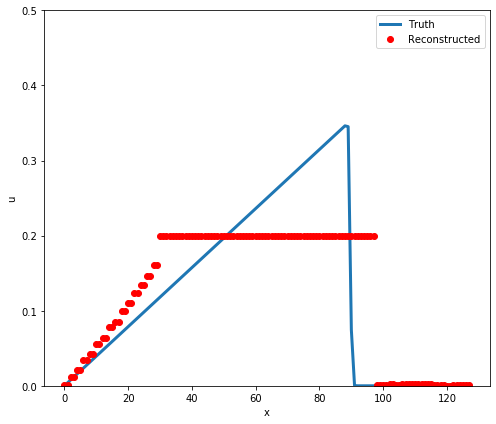

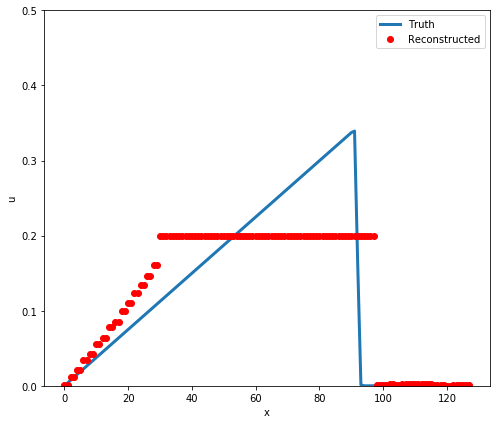

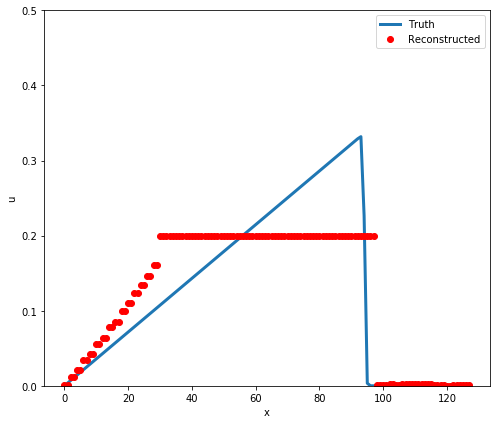

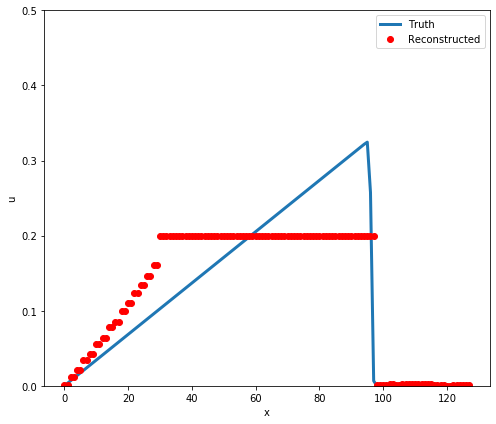

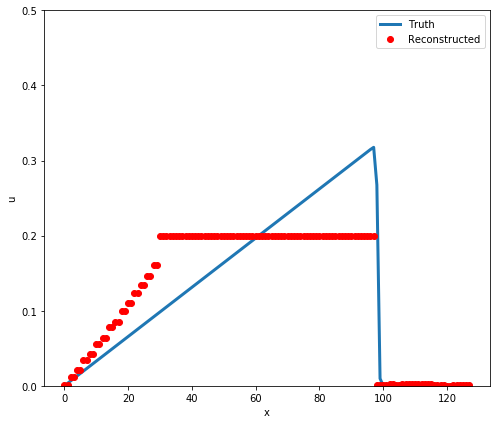

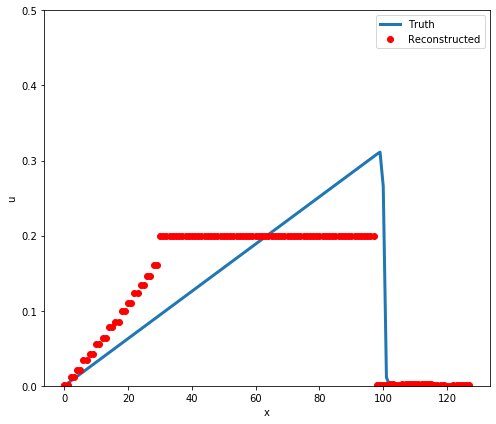

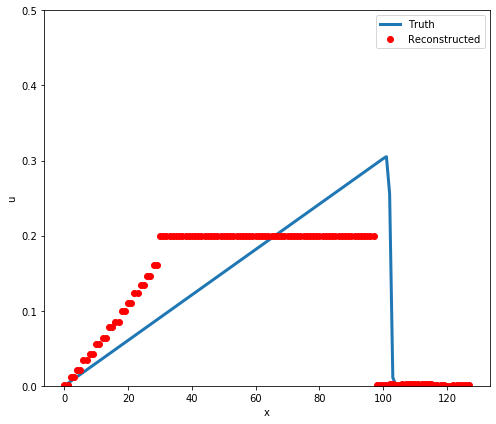

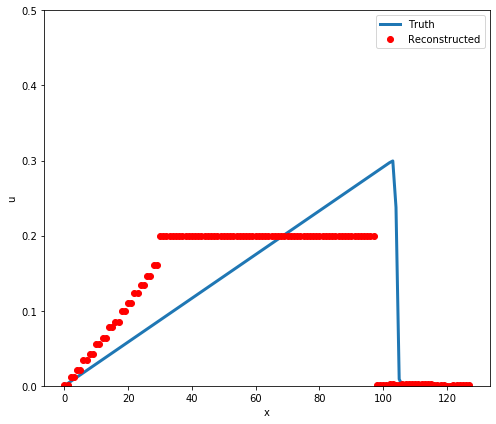

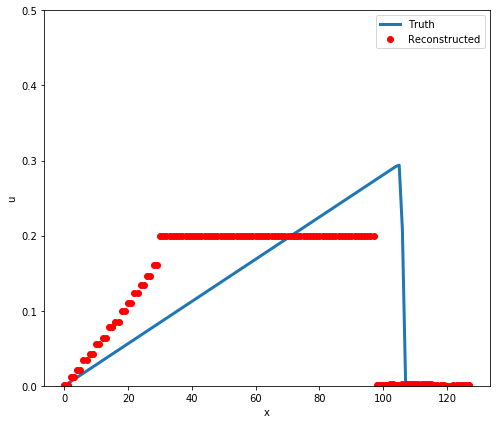

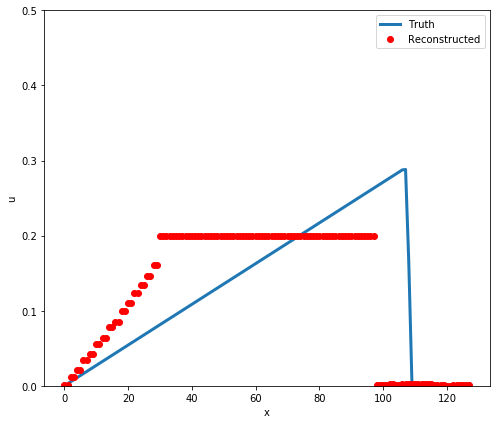

In [9]:
import matplotlib.pyplot as plt
model.load_weights(weights_filepath)
recoded_1 = model.predict(snapshots_valid)[0]

for i in range(0,snapshots_valid.shape[0],50):
    plt.figure(figsize=(7,6))
    plt.plot(snapshots_valid[i,:,0:],label='Truth',linewidth=3)
    plt.plot(recoded_1[i,:,0:],'ro',label='Reconstructed')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.ylim((0,0.5))
    plt.tight_layout()
    plt.legend()
    plt.show()